In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

import pickle
import time

# Define Func

In [6]:
def visualize_training_results(results):
    history = results.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    # fig.suptitle('Horizontally stacked subplots')

    ax1.plot(history['accuracy'])
    ax1.plot(history['loss'])
    ax1.legend(['accuracy', 'loss'])
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(history['val_accuracy'])
    ax2.plot(history['accuracy'])
    ax2.legend(['val_accuracy', 'accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy');

In [7]:
def heatmap_predicted_results(X_test, y_test, model):
    y_predicted = model.predict(X_test) > 0.5
    mat = confusion_matrix(y_test, y_predicted)

    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, ax=ax)

# Import Data

In [8]:
# df = pd.read_csv('processed_df\metacritic_comments_nlp.csv')
# df.head()

df = pickle.load(open('processed_df\preprocessed_nlp_30p.pkl','rb'))
df.head()

,Title,Userscore,Comment,lang
211190,Star Wars: Battlefront II,2.0,there nothing quite gun entire platoon clone d...,en
39249,The Witcher 3: Wild Hunt,10.0,game absolutely gorgeous run steady gtx hairwo...,en
204931,This War of Mine,10.0,really good game didnt expect first survival g...,en
75752,Golden Sun,10.0,people eagerly anticipate initial release game...,en
199503,Assassin's Creed IV: Black Flag,8.0,best assassin creed far open world fresh missi...,en


In [9]:
df.shape

(74709, 4)

In [11]:
print(f'shape before: {df.shape}')
df = df[df['Comment'] != '']
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
print(f'shape after: {df.shape}')


shape before: (72477, 4)
shape after: (70569, 4)


# Train test split

In [12]:
X = df['Comment']
y = df['Userscore']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# TFIDF text

In [13]:
start = time.time()

bow_vec = TfidfVectorizer(min_df=0.05, max_df=0.95)
X_tr_proc = bow_vec.fit_transform(X_train)
X_te_proc = bow_vec.transform(X_test)

end = time.time()
print(f'{end-start} secs slipped..')

3.041321039199829 secs slipped..


In [15]:
feat_names = bow_vec.get_feature_names()

c:\Users\qwswe\Anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
bow_mat_tr = pd.DataFrame(X_tr_proc.toarray(), columns = feat_names)
bow_mat_te = pd.DataFrame(X_te_proc.toarray(), columns = feat_names)

In [17]:
bow_mat_tr.shape

(49398, 167)

# MODEL

- 1

In [18]:
model_1 = Sequential()
model_1.add(Dense(64, activation='relu', input_shape=(167,)))
model_1.add(Dense(30, activation='relu'))
model_1.add(Dense(1, activation='linear'))

opt = Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model_1.compile(loss = "mean_squared_error", optimizer=opt, metrics=['mean_absolute_error'])

In [19]:
results_1 = model_1.fit(bow_mat_tr, y_train, validation_split = 0.2, epochs=50, batch_size=256)

Epoch 1/50
155/155 [==============================] - 2s 4ms/step - loss: 52.6714 - mean_absolute_error: 6.7782 - val_loss: 23.0589 - val_mean_absolute_error: 4.3755
Epoch 2/50
155/155 [==============================] - 0s 3ms/step - loss: 11.7657 - mean_absolute_error: 2.9267 - val_loss: 8.9016 - val_mean_absolute_error: 2.4537
Epoch 3/50
155/155 [==============================] - 0s 3ms/step - loss: 8.0454 - mean_absolute_error: 2.3212 - val_loss: 7.3077 - val_mean_absolute_error: 2.1830
Epoch 4/50
155/155 [==============================] - 0s 3ms/step - loss: 6.6876 - mean_absolute_error: 2.0681 - val_loss: 6.1793 - val_mean_absolute_error: 1.9586
Epoch 5/50
155/155 [==============================] - 0s 3ms/step - loss: 5.8376 - mean_absolute_error: 1.8956 - val_loss: 5.5467 - val_mean_absolute_error: 1.8337
Epoch 6/50
155/155 [==============================] - 0s 3ms/step - loss: 5.3832 - mean_absolute_error: 1.8048 - val_loss: 5.2016 - val_mean_absolute_error: 1.7659
Epoch 7/50
15

In [20]:
history_dict = results_1.history
history_dict.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

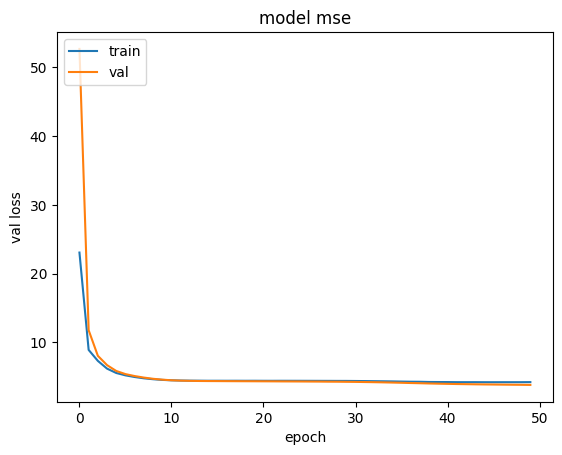

In [21]:
plt.plot(results_1.history['val_loss'])
plt.plot(results_1.history['loss'])
plt.title('model mse')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

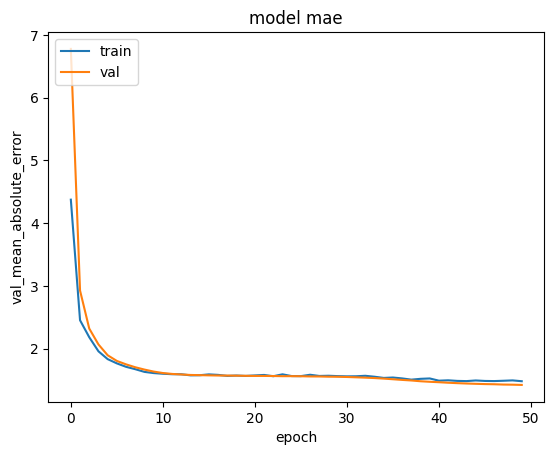

In [22]:
plt.plot(results_1.history['val_mean_absolute_error'])
plt.plot(results_1.history['mean_absolute_error'])
plt.title('model mae')
plt.ylabel('val_mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
model_1.evaluate(bow_mat_te, y_test)

662/662 [==============================] - 1s 2ms/step - loss: 4.3531 - mean_absolute_error: 1.4965


[4.353050708770752, 1.4964686632156372]

- 2

In [72]:
model_2 = Sequential()
model_2.add(Dense(64, activation='relu', input_shape=(155,)))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(16, activation='relu'))
model_2.add(Dense(16, activation='relu'))
model_2.add(Dense(1, activation='linear'))

opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model_2.compile(loss = "mean_squared_error", optimizer=opt, metrics=['mean_squared_error'])

In [73]:
results_2 = model_2.fit(bow_mat_tr, y_train, validation_split = 0.2, epochs=50, batch_size=256)

Epoch 1/50
164/164 [==============================] - 1s 4ms/step - loss: 20.6882 - mean_squared_error: 20.6882 - val_loss: 5.7531 - val_mean_squared_error: 5.7531
Epoch 2/50
164/164 [==============================] - 0s 3ms/step - loss: 4.8445 - mean_squared_error: 4.8445 - val_loss: 4.5535 - val_mean_squared_error: 4.5535
Epoch 3/50
164/164 [==============================] - 0s 3ms/step - loss: 4.5341 - mean_squared_error: 4.5341 - val_loss: 4.4763 - val_mean_squared_error: 4.4763
Epoch 4/50
164/164 [==============================] - 0s 3ms/step - loss: 4.4932 - mean_squared_error: 4.4932 - val_loss: 4.4675 - val_mean_squared_error: 4.4675
Epoch 5/50
164/164 [==============================] - 0s 3ms/step - loss: 4.4502 - mean_squared_error: 4.4502 - val_loss: 4.4457 - val_mean_squared_error: 4.4457
Epoch 6/50
164/164 [==============================] - 0s 3ms/step - loss: 4.4283 - mean_squared_error: 4.4283 - val_loss: 4.4398 - val_mean_squared_error: 4.4398
Epoch 7/50
164/164 [======

In [74]:
history_dict = results_2.history
history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

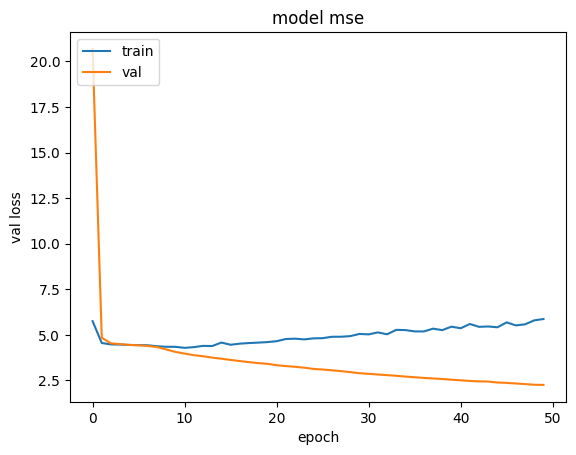

In [75]:
plt.plot(results_2.history['val_loss'])
plt.plot(results_2.history['loss'])
plt.title('model mse')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [76]:
model_2.evaluate(bow_mat_te, y_test)

701/701 [==============================] - 1s 2ms/step - loss: 5.9070 - mean_squared_error: 5.9070


[5.907035827636719, 5.907035827636719]